In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scandataset import SCANDataset
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp1 import *

In [2]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'mps'

In [3]:
MAX_LEN = 50

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

paths = []

for exponent in range(0, 7):
    pow2 = 2**exponent
    paths.append((
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_train_simple_p{pow2}.txt'),
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_test_simple_p{pow2}.txt')
    ))

paths.append((
    os.path.join('data', 'simple_split', f'tasks_train_simple.txt'),
    os.path.join('data', 'simple_split', f'tasks_test_simple.txt')
))

In [4]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()
    
    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [5]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = torch.argmax(output, -1)

            for i in range(output.size(0)):
                tgt_tokens = tgt_output[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

In [6]:
def eval_loop_autoregressive(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

  5%|▌         | 1/20 [00:11<03:43, 11.75s/it]

Epoch 1, Loss: 1.8916


 10%|█         | 2/20 [00:22<03:25, 11.43s/it]

Epoch 2, Loss: 1.5489


 15%|█▌        | 3/20 [00:34<03:12, 11.34s/it]

Epoch 3, Loss: 1.3496


 20%|██        | 4/20 [00:45<03:00, 11.30s/it]

Epoch 4, Loss: 1.1963


 25%|██▌       | 5/20 [00:56<02:49, 11.30s/it]

Epoch 5, Loss: 1.0717


 30%|███       | 6/20 [01:07<02:37, 11.28s/it]

Epoch 6, Loss: 0.9653


 35%|███▌      | 7/20 [01:19<02:26, 11.26s/it]

Epoch 7, Loss: 0.8920


 40%|████      | 8/20 [01:30<02:14, 11.24s/it]

Epoch 8, Loss: 0.8356


 45%|████▌     | 9/20 [01:41<02:03, 11.24s/it]

Epoch 9, Loss: 0.7776


 50%|█████     | 10/20 [01:52<01:52, 11.24s/it]

Epoch 10, Loss: 0.7538


 55%|█████▌    | 11/20 [02:04<01:41, 11.24s/it]

Epoch 11, Loss: 0.7036


 60%|██████    | 12/20 [02:15<01:29, 11.24s/it]

Epoch 12, Loss: 0.6840


 65%|██████▌   | 13/20 [02:26<01:18, 11.24s/it]

Epoch 13, Loss: 0.6432


 70%|███████   | 14/20 [02:37<01:07, 11.23s/it]

Epoch 14, Loss: 0.6338


 75%|███████▌  | 15/20 [02:49<00:56, 11.24s/it]

Epoch 15, Loss: 0.6000


 80%|████████  | 16/20 [03:00<00:44, 11.24s/it]

Epoch 16, Loss: 0.5655


 85%|████████▌ | 17/20 [03:11<00:33, 11.27s/it]

Epoch 17, Loss: 0.5587


 90%|█████████ | 18/20 [03:22<00:22, 11.26s/it]

Epoch 18, Loss: 0.5259


 95%|█████████▌| 19/20 [03:34<00:11, 11.25s/it]

Epoch 19, Loss: 0.5195


100%|██████████| 20/20 [03:45<00:00, 11.27s/it]

Epoch 20, Loss: 0.5171


Token-level accuracy: 0.7332984928689437, Sequence-level accuracy: 0.06357180812521135


  5%|▌         | 1/20 [00:11<03:38, 11.49s/it]

Epoch 1, Loss: 1.8378


 10%|█         | 2/20 [00:22<03:24, 11.39s/it]

Epoch 2, Loss: 1.3793


 15%|█▌        | 3/20 [00:34<03:12, 11.35s/it]

Epoch 3, Loss: 1.0810


 20%|██        | 4/20 [00:45<03:01, 11.34s/it]

Epoch 4, Loss: 0.9460


 25%|██▌       | 5/20 [00:56<02:50, 11.34s/it]

Epoch 5, Loss: 0.8512


 30%|███       | 6/20 [01:08<02:38, 11.34s/it]

Epoch 6, Loss: 0.7917


 35%|███▌      | 7/20 [01:19<02:27, 11.35s/it]

Epoch 7, Loss: 0.7495


 40%|████      | 8/20 [01:30<02:16, 11.35s/it]

Epoch 8, Loss: 0.7155


 45%|████▌     | 9/20 [01:42<02:05, 11.38s/it]

Epoch 9, Loss: 0.6865


 50%|█████     | 10/20 [01:53<01:53, 11.35s/it]

Epoch 10, Loss: 0.6408


 55%|█████▌    | 11/20 [02:04<01:42, 11.34s/it]

Epoch 11, Loss: 0.6156


 60%|██████    | 12/20 [02:16<01:30, 11.33s/it]

Epoch 12, Loss: 0.5943


 65%|██████▌   | 13/20 [02:27<01:19, 11.33s/it]

Epoch 13, Loss: 0.5616


 70%|███████   | 14/20 [02:38<01:07, 11.32s/it]

Epoch 14, Loss: 0.5396


 75%|███████▌  | 15/20 [02:50<00:56, 11.31s/it]

Epoch 15, Loss: 0.5192


 80%|████████  | 16/20 [03:01<00:45, 11.30s/it]

Epoch 16, Loss: 0.4843


 85%|████████▌ | 17/20 [03:12<00:33, 11.31s/it]

Epoch 17, Loss: 0.4633


 90%|█████████ | 18/20 [03:23<00:22, 11.30s/it]

Epoch 18, Loss: 0.4492


 95%|█████████▌| 19/20 [03:35<00:11, 11.30s/it]

Epoch 19, Loss: 0.4247


100%|██████████| 20/20 [03:46<00:00, 11.33s/it]

Epoch 20, Loss: 0.4034


Token-level accuracy: 0.800801679579969, Sequence-level accuracy: 0.07866484481748975


  5%|▌         | 1/20 [00:12<03:51, 12.21s/it]

Epoch 1, Loss: 1.7014


 10%|█         | 2/20 [00:24<03:38, 12.16s/it]

Epoch 2, Loss: 1.0967


 15%|█▌        | 3/20 [00:36<03:26, 12.12s/it]

Epoch 3, Loss: 0.8350


 20%|██        | 4/20 [00:48<03:13, 12.11s/it]

Epoch 4, Loss: 0.7793


 25%|██▌       | 5/20 [01:00<03:01, 12.11s/it]

Epoch 5, Loss: 0.7060


 30%|███       | 6/20 [01:12<02:49, 12.11s/it]

Epoch 6, Loss: 0.6794


 35%|███▌      | 7/20 [01:24<02:37, 12.10s/it]

Epoch 7, Loss: 0.6152


 40%|████      | 8/20 [01:36<02:25, 12.10s/it]

Epoch 8, Loss: 0.5594


 45%|████▌     | 9/20 [01:48<02:13, 12.10s/it]

Epoch 9, Loss: 0.5488


 50%|█████     | 10/20 [02:01<02:01, 12.15s/it]

Epoch 10, Loss: 0.4908


 55%|█████▌    | 11/20 [02:13<01:49, 12.13s/it]

Epoch 11, Loss: 0.4703


 60%|██████    | 12/20 [02:25<01:36, 12.12s/it]

Epoch 12, Loss: 0.4635


 65%|██████▌   | 13/20 [02:37<01:24, 12.14s/it]

Epoch 13, Loss: 0.4089


 70%|███████   | 14/20 [02:49<01:13, 12.19s/it]

Epoch 14, Loss: 0.3808


 75%|███████▌  | 15/20 [03:02<01:00, 12.20s/it]

Epoch 15, Loss: 0.3350


 80%|████████  | 16/20 [03:14<00:48, 12.19s/it]

Epoch 16, Loss: 0.3120


 85%|████████▌ | 17/20 [03:26<00:36, 12.20s/it]

Epoch 17, Loss: 0.3177


 90%|█████████ | 18/20 [03:38<00:24, 12.20s/it]

Epoch 18, Loss: 0.2648


 95%|█████████▌| 19/20 [03:50<00:12, 12.15s/it]

Epoch 19, Loss: 0.2386


100%|██████████| 20/20 [04:02<00:00, 12.14s/it]

Epoch 20, Loss: 0.2375


Token-level accuracy: 0.9086354903820433, Sequence-level accuracy: 0.21595098136893495


  5%|▌         | 1/20 [00:12<03:58, 12.55s/it]

Epoch 1, Loss: 1.3517


 10%|█         | 2/20 [00:25<03:45, 12.51s/it]

Epoch 2, Loss: 0.8120


 15%|█▌        | 3/20 [00:37<03:31, 12.46s/it]

Epoch 3, Loss: 0.7087


 20%|██        | 4/20 [00:49<03:18, 12.42s/it]

Epoch 4, Loss: 0.6102


 25%|██▌       | 5/20 [01:02<03:06, 12.41s/it]

Epoch 5, Loss: 0.5297


 30%|███       | 6/20 [01:14<02:53, 12.37s/it]

Epoch 6, Loss: 0.4666


 35%|███▌      | 7/20 [01:26<02:40, 12.34s/it]

Epoch 7, Loss: 0.3981


 40%|████      | 8/20 [01:39<02:29, 12.44s/it]

Epoch 8, Loss: 0.3278


 45%|████▌     | 9/20 [01:51<02:16, 12.45s/it]

Epoch 9, Loss: 0.2819


 50%|█████     | 10/20 [02:04<02:04, 12.47s/it]

Epoch 10, Loss: 0.2410


 55%|█████▌    | 11/20 [02:16<01:52, 12.45s/it]

Epoch 11, Loss: 0.2080


 60%|██████    | 12/20 [02:29<01:39, 12.42s/it]

Epoch 12, Loss: 0.1821


 65%|██████▌   | 13/20 [02:41<01:27, 12.44s/it]

Epoch 13, Loss: 0.1626


 70%|███████   | 14/20 [02:53<01:14, 12.39s/it]

Epoch 14, Loss: 0.1444


 75%|███████▌  | 15/20 [03:06<01:02, 12.43s/it]

Epoch 15, Loss: 0.1258


 80%|████████  | 16/20 [03:18<00:49, 12.45s/it]

Epoch 16, Loss: 0.1145


 85%|████████▌ | 17/20 [03:31<00:37, 12.42s/it]

Epoch 17, Loss: 0.1061


 90%|█████████ | 18/20 [03:43<00:24, 12.38s/it]

Epoch 18, Loss: 0.0936


 95%|█████████▌| 19/20 [03:56<00:12, 12.45s/it]

Epoch 19, Loss: 0.0860


100%|██████████| 20/20 [04:08<00:00, 12.43s/it]

Epoch 20, Loss: 0.0821


Token-level accuracy: 0.9669124845004242, Sequence-level accuracy: 0.628027861524067


  5%|▌         | 1/20 [00:12<04:05, 12.94s/it]

Epoch 1, Loss: 1.0824


 10%|█         | 2/20 [00:26<03:54, 13.05s/it]

Epoch 2, Loss: 0.6577


 15%|█▌        | 3/20 [00:38<03:40, 12.96s/it]

Epoch 3, Loss: 0.5180


 20%|██        | 4/20 [00:51<03:27, 12.97s/it]

Epoch 4, Loss: 0.4159


 25%|██▌       | 5/20 [01:04<03:14, 12.98s/it]

Epoch 5, Loss: 0.2576


 30%|███       | 6/20 [01:17<03:01, 12.99s/it]

Epoch 6, Loss: 0.1704


 35%|███▌      | 7/20 [01:30<02:49, 13.00s/it]

Epoch 7, Loss: 0.1301


 40%|████      | 8/20 [01:44<02:36, 13.04s/it]

Epoch 8, Loss: 0.1068


 45%|████▌     | 9/20 [01:57<02:23, 13.07s/it]

Epoch 9, Loss: 0.0846


 50%|█████     | 10/20 [02:10<02:10, 13.06s/it]

Epoch 10, Loss: 0.0741


 55%|█████▌    | 11/20 [02:23<01:57, 13.03s/it]

Epoch 11, Loss: 0.0690


 60%|██████    | 12/20 [02:36<01:44, 13.06s/it]

Epoch 12, Loss: 0.0595


 65%|██████▌   | 13/20 [02:49<01:32, 13.16s/it]

Epoch 13, Loss: 0.0542


 70%|███████   | 14/20 [03:02<01:19, 13.17s/it]

Epoch 14, Loss: 0.0467


 75%|███████▌  | 15/20 [03:16<01:05, 13.16s/it]

Epoch 15, Loss: 0.0421


 80%|████████  | 16/20 [03:29<00:52, 13.15s/it]

Epoch 16, Loss: 0.0373


 85%|████████▌ | 17/20 [03:42<00:39, 13.08s/it]

Epoch 17, Loss: 0.0352


 90%|█████████ | 18/20 [03:55<00:26, 13.04s/it]

Epoch 18, Loss: 0.0321


 95%|█████████▌| 19/20 [04:08<00:13, 13.03s/it]

Epoch 19, Loss: 0.0310


100%|██████████| 20/20 [04:21<00:00, 13.08s/it]

Epoch 20, Loss: 0.0259


Token-level accuracy: 0.9948125976364526, Sequence-level accuracy: 0.930999146029035


  5%|▌         | 1/20 [00:14<04:33, 14.39s/it]

Epoch 1, Loss: 0.8619


 10%|█         | 2/20 [00:28<04:16, 14.24s/it]

Epoch 2, Loss: 0.4415


 15%|█▌        | 3/20 [00:42<04:01, 14.23s/it]

Epoch 3, Loss: 0.2168


 20%|██        | 4/20 [00:57<03:49, 14.37s/it]

Epoch 4, Loss: 0.1367


 25%|██▌       | 5/20 [01:11<03:34, 14.27s/it]

Epoch 5, Loss: 0.0969


 30%|███       | 6/20 [01:25<03:18, 14.21s/it]

Epoch 6, Loss: 0.0745


 35%|███▌      | 7/20 [01:39<03:04, 14.21s/it]

Epoch 7, Loss: 0.0635


 40%|████      | 8/20 [01:53<02:50, 14.20s/it]

Epoch 8, Loss: 0.0482


 45%|████▌     | 9/20 [02:08<02:36, 14.21s/it]

Epoch 9, Loss: 0.0412


 50%|█████     | 10/20 [02:22<02:21, 14.20s/it]

Epoch 10, Loss: 0.0368


 55%|█████▌    | 11/20 [02:36<02:07, 14.17s/it]

Epoch 11, Loss: 0.0320


 60%|██████    | 12/20 [02:50<01:53, 14.21s/it]

Epoch 12, Loss: 0.0323


 65%|██████▌   | 13/20 [03:05<01:39, 14.24s/it]

Epoch 13, Loss: 0.0260


 70%|███████   | 14/20 [03:19<01:25, 14.23s/it]

Epoch 14, Loss: 0.0250


 75%|███████▌  | 15/20 [03:33<01:11, 14.20s/it]

Epoch 15, Loss: 0.0189


 80%|████████  | 16/20 [03:47<00:56, 14.17s/it]

Epoch 16, Loss: 0.0199


 85%|████████▌ | 17/20 [04:01<00:42, 14.15s/it]

Epoch 17, Loss: 0.0181


 90%|█████████ | 18/20 [04:15<00:28, 14.14s/it]

Epoch 18, Loss: 0.0160


 95%|█████████▌| 19/20 [04:29<00:14, 14.12s/it]

Epoch 19, Loss: 0.0146


100%|██████████| 20/20 [04:43<00:00, 14.20s/it]

Epoch 20, Loss: 0.0159


Token-level accuracy: 0.9993230416035084, Sequence-level accuracy: 0.9903650045713482


  5%|▌         | 1/20 [00:16<05:16, 16.68s/it]

Epoch 1, Loss: 0.6575


 10%|█         | 2/20 [00:33<04:57, 16.53s/it]

Epoch 2, Loss: 0.2320


 15%|█▌        | 3/20 [00:49<04:39, 16.47s/it]

Epoch 3, Loss: 0.1028


 20%|██        | 4/20 [01:06<04:24, 16.54s/it]

Epoch 4, Loss: 0.0614


 25%|██▌       | 5/20 [01:23<04:09, 16.66s/it]

Epoch 5, Loss: 0.0441


 30%|███       | 6/20 [01:39<03:52, 16.59s/it]

Epoch 6, Loss: 0.0330


 35%|███▌      | 7/20 [01:55<03:34, 16.54s/it]

Epoch 7, Loss: 0.0234


 40%|████      | 8/20 [02:12<03:17, 16.50s/it]

Epoch 8, Loss: 0.0196


 45%|████▌     | 9/20 [02:28<03:01, 16.48s/it]

Epoch 9, Loss: 0.0182


 50%|█████     | 10/20 [02:45<02:45, 16.55s/it]

Epoch 10, Loss: 0.0118


 55%|█████▌    | 11/20 [03:01<02:28, 16.53s/it]

Epoch 11, Loss: 0.0134


 60%|██████    | 12/20 [03:18<02:11, 16.48s/it]

Epoch 12, Loss: 0.0092


 65%|██████▌   | 13/20 [03:34<01:54, 16.38s/it]

Epoch 13, Loss: 0.0123


 70%|███████   | 14/20 [03:50<01:38, 16.37s/it]

Epoch 14, Loss: 0.0124


 75%|███████▌  | 15/20 [04:07<01:21, 16.35s/it]

Epoch 15, Loss: 0.0086


 80%|████████  | 16/20 [04:23<01:05, 16.29s/it]

Epoch 16, Loss: 0.0085


 85%|████████▌ | 17/20 [04:39<00:48, 16.32s/it]

Epoch 17, Loss: 0.0069


 90%|█████████ | 18/20 [04:56<00:32, 16.36s/it]

Epoch 18, Loss: 0.0078


 95%|█████████▌| 19/20 [05:12<00:16, 16.34s/it]

Epoch 19, Loss: 0.0077


100%|██████████| 20/20 [05:28<00:00, 16.43s/it]

Epoch 20, Loss: 0.0051


Token-level accuracy: 0.9999158729120124, Sequence-level accuracy: 0.9988044633368757


  5%|▌         | 1/20 [00:17<05:35, 17.64s/it]

Epoch 1, Loss: 0.5585


 10%|█         | 2/20 [00:35<05:14, 17.49s/it]

Epoch 2, Loss: 0.1281


 15%|█▌        | 3/20 [00:52<04:55, 17.40s/it]

Epoch 3, Loss: 0.0634


 20%|██        | 4/20 [01:09<04:37, 17.36s/it]

Epoch 4, Loss: 0.0407


 25%|██▌       | 5/20 [01:26<04:20, 17.34s/it]

Epoch 5, Loss: 0.0274


 30%|███       | 6/20 [01:44<04:03, 17.42s/it]

Epoch 6, Loss: 0.0200


 35%|███▌      | 7/20 [02:01<03:46, 17.42s/it]

Epoch 7, Loss: 0.0159


 40%|████      | 8/20 [02:19<03:28, 17.41s/it]

Epoch 8, Loss: 0.0136


 45%|████▌     | 9/20 [02:36<03:11, 17.42s/it]

Epoch 9, Loss: 0.0116


 50%|█████     | 10/20 [02:55<02:58, 17.87s/it]

Epoch 10, Loss: 0.0114


 55%|█████▌    | 11/20 [03:13<02:40, 17.82s/it]

Epoch 11, Loss: 0.0099


 60%|██████    | 12/20 [03:31<02:22, 17.82s/it]

Epoch 12, Loss: 0.0096


 65%|██████▌   | 13/20 [03:49<02:05, 17.94s/it]

Epoch 13, Loss: 0.0066


 70%|███████   | 14/20 [04:07<01:47, 17.98s/it]

Epoch 14, Loss: 0.0084


 75%|███████▌  | 15/20 [04:25<01:30, 18.14s/it]

Epoch 15, Loss: 0.0067


 80%|████████  | 16/20 [04:44<01:12, 18.13s/it]

Epoch 16, Loss: 0.0074


 85%|████████▌ | 17/20 [05:01<00:53, 17.98s/it]

Epoch 17, Loss: 0.0056


 90%|█████████ | 18/20 [05:19<00:35, 17.89s/it]

Epoch 18, Loss: 0.0057


 95%|█████████▌| 19/20 [05:37<00:18, 18.00s/it]

Epoch 19, Loss: 0.0079


100%|██████████| 20/20 [05:55<00:00, 17.79s/it]

Epoch 20, Loss: 0.0061


Token-level accuracy: 0.9997316336799732, Sequence-level accuracy: 0.9961740793878527


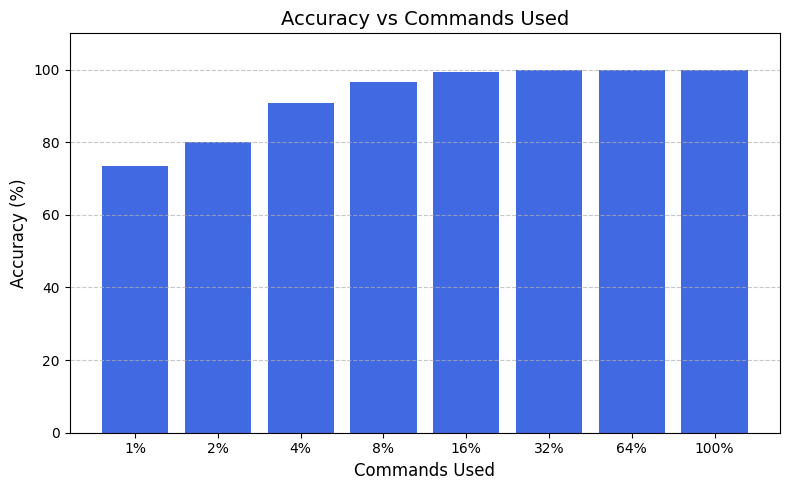

In [7]:
N = 8
epochs = 20
Y = []

for i in range(N):
    train_path, test_path = paths[i]

    dataset_train = SCANDataset(
        file_path=train_path,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        file_path=test_path,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs)

    token_accuracy, seq_accuracy = eval_loop(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    Y.append(token_accuracy * 100)

X = ['1%', '2%', '4%', '8%', '16%', '32%', '64%', '100%']

plt.figure(figsize=(8, 5))
plt.bar(X, Y, color='royalblue')
plt.xlabel('Commands Used', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110)
plt.title('Accuracy vs Commands Used', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()